In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from skimage.color import rgba2rgb
import cv2
from IPython.display import display, clear_output
from math import *
import time

from os import makedirs, path
from copy import deepcopy

from tqdm import tqdm

import pygame

C:\Users\Heysoos\anaconda3\envs\torchstuff\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pygame 2.1.2 (SDL 2.0.18, Python 3.9.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# brush properties
r = 5
s = 1

def LMB_make(state, r=5, s=1):
    '''
    left click to make
    r: radius of brush
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)

    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = torch.exp(-rm**2 / s**2)
    blur = torch.where(rm <= 1., blur, 0.) # circular mask

    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, 1, i, j] = state[:, 1, i, j] + 5.
    return state


def RMB_del(state, r=5, s=1):
    '''
    right click to erase
    r: radius of eraser
    s: smoothing / sigma
    '''
    xcl, ycl = pygame.mouse.get_pos()
    xcl, ycl = int(xcl/UPSCALE), int(ycl/UPSCALE)

    # radial blur
    xm, ym = torch.meshgrid(torch.linspace(-1, 1, 2*r), torch.linspace(-1, 1, 2*r))
    rm = torch.sqrt(xm**2 + ym**2).type(torch.double)
    blur = (1 - torch.exp(-rm**2 / s**2))
    blur = torch.where(rm <= 1., blur, 1.) # circular mask

    xslice = range(xcl - r, xcl + r)
    yslice = range(ycl - r, ycl + r)
    for count_i, i in enumerate(xslice):
        for count_j, j in enumerate(yslice):
            i = i % RESX
            j = j % RESY
            state[:, 1, i, j] = state[:, 1, i, j] - 0.2
    return state

def print_something(something):
    fps = f'{something:.3f}'
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf

def plot_classification_scores(score1, score2, correct_class, width=400, height=300):
    # Normalize scores to fit in the graph
    score1 = max(min(score1, 1), -1)  # Clamp scores to be within [-1, 1]
    score2 = max(min(score2, 1), -1)

    # Calculate the heights of the bars
    BAR_WIDTH = width // 4
    BAR_HEIGHT = height // 2

    height1 = (score1 + 1) * (BAR_HEIGHT / 2)  # Adjusted for fixed y-axis range
    height2 = (score2 + 1) * (BAR_HEIGHT / 2)

    # Create a surface for drawing the graph
    graph_surface = pygame.Surface((width, height), pygame.SRCALPHA)
    graph_surface.fill((255, 255, 255, 0))  # Fill with transparent color

    # Draw the bars
    predicted = np.argmax([score1, score2])
    bar_colors = np.zeros((2, 3))
    GREEN = np.array([0, 255, 0])
    RED = np.array([255, 0, 0])
    if  predicted == correct_class:
        # Highlight the correct class
        bar_colors[predicted] = GREEN
    else:
        bar_colors[predicted] = RED
    pygame.draw.rect(graph_surface, bar_colors[0], (width // 4, height - height1, BAR_WIDTH, height1))
    pygame.draw.rect(graph_surface, bar_colors[1], (2 * width // 4, height - height2, BAR_WIDTH, height2))

    # if correct_class == 0:
    #     pygame.draw.rect(graph_surface, correct_color, (width // 4, height - height1, BAR_WIDTH, height1))
    # elif correct_class == 1:
    #     pygame.draw.rect(graph_surface, correct_color, (2 * width // 4, height - height2, BAR_WIDTH, height2))

    return graph_surface

def WHEEL_permute(cdim_order, direction):
    cdim_order = np.mod(np.add(cdim_order, direction), len(cdim_order))

    return cdim_order

def min_max(mat):
    return (mat - mat.min()) / (mat.max() - mat.min())

In [3]:
class Rule(nn.Module):
    def __init__(self, CHANNELS=8, FILTERS=1, HIDDEN=16, RES=50):
        super().__init__()
        self.channels = CHANNELS
        self.filters = FILTERS
        self.hidden = HIDDEN
        self.alpha = torch.nn.Parameter(torch.tensor([0.]))

        # for forward_perception
        self.ident = torch.tensor([[0.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0]]).cuda()
        self.sobel_x = torch.tensor([[-1.0, 0.0, 1.0], [-2.0, 0.0, 2.0], [-1.0, 0.0, 1.0]]).cuda() / 8.0
        self.lap = torch.tensor([[1.0, 2.0, 1.0], [2.0, -12, 2.0], [1.0, 2.0, 1.0]]).cuda() / 16.0

        # self.filters = [nn.Parameter(torch.randn(3, 3).cuda())
        #                 for i in range(2)]

        self.w1 = torch.nn.Conv2d(CHANNELS * 4, HIDDEN, 1)
        self.w1.bias.data.zero_()
        self.w2 = torch.nn.Conv2d(HIDDEN, CHANNELS, 1, bias=False)

        # read in layer is used to project from 1D -> CA grid via 3 input channels
        # readout layer is used to project from CA grid via 3 output channels -> num_classes (2)
        self.readin = torch.nn.Linear(1, RES*RES*1)
        self.readout = torch.nn.Linear(RES*RES*1, 2, bias=True)
        # self.w2.weight.data.zero_()
        ###########################################

class CA(nn.Module):
    def __init__(self, CHANNELS=8, FILTERS=1, HIDDEN=16, RES=50):
        super().__init__()
        self.channels = CHANNELS
        self.filters = FILTERS
        self.hidden = HIDDEN
        self.res = RES


        self.rule = Rule(CHANNELS, FILTERS, HIDDEN, RES)

    def initGrid(self, BS):
        return torch.cuda.FloatTensor(2 * np.random.rand(BS, self.channels, self.res, self.res) - 1)

    def seed(self, RES, n):
        seed = torch.FloatTensor(np.zeros((n, self.channels, RES, RES)))
        return seed

    def perchannel_conv(self, x, filters):
        '''filters: [filter_n, h, w]'''
        b, ch, h, w = x.shape
        y = x.reshape(b * ch, 1, h, w)
        y = torch.nn.functional.pad(y, [1, 1, 1, 1], 'circular')
        y = torch.nn.functional.conv2d(y, filters[:, None])
        return y.reshape(b, -1, h, w)

    def perception(self, x):
        filters = [self.rule.ident, self.rule.sobel_x, self.rule.sobel_x.T, self.rule.lap]
        return self.perchannel_conv(x, torch.stack(filters))

    def forward(self, x, dt=1, update_rate=0.5):
        b, ch, h, w = x.shape
        y = self.perception(x)

        y = F.leaky_relu(self.rule.w1(y))
        y = self.rule.w2(y)

        # update_mask = (torch.rand(b, 1, h, w) + update_rate).floor().cuda()
        # y = dt * y * update_mask
        y = dt * y
        alpha = torch.sigmoid(self.rule.alpha)
        res = (1 - alpha) * x + alpha * y
        # res = torch.clamp(x + y, 0, 1)
        # res = F.leaky_relu(x + y)
        return res

# Training

Let's train the model now in the N-Parity task. We will project the 1-D timeseries in 3 of the 8 channel dimensions of all the cells in the grid (size=1 x RESxRESx3). We will then read out from 3 different channels from the entire grid to get a classification (size=RESxRESx3 x 1).

In [4]:
def generate_binary_sequence(M):
    return (torch.rand(M) < 0.5) * 2. - 1.

def make_batch_Nbit_pair_parity(Ns, M, bs):
    with torch.no_grad():
        sequences = [generate_binary_sequence(M).unsqueeze(-1) for i in range(bs)]
        labels = [torch.stack([get_parity(s, N) for s in sequences]) for N in Ns]

    return torch.stack(sequences), labels

def get_parity(vec, N):
    return  (((vec + 1)/2)[-N:].sum() % 2).long()

def pad_to(mat, shape_to):
    shape = mat.shape
    # shape diff
    shd = [shape_to[0]-shape[2], shape_to[1]-shape[3]]
    pad = [0, shd[0], shd[1]//2, shd[1]//2]
    return F.pad(mat, pad, mode='constant')

In [5]:
criterion = nn.CrossEntropyLoss()

In [6]:
CHANNELS=8
FILTERS=1
HIDDEN=16

RES = 20
BATCH_SIZE = 128

device = 'cuda'
ca = CA(CHANNELS=CHANNELS,
        FILTERS=FILTERS,
        HIDDEN=HIDDEN,
        RES=RES,
        ).to(device)

In [7]:
total_numel = 0
for n, p in ca.named_parameters():
    print(f'{n:<20} {p.numel():>5}')
    total_numel += p.numel()

print(f'{"Total # parameters:":<20} {total_numel:>5}')

rule.alpha               1
rule.w1.weight         512
rule.w1.bias            16
rule.w2.weight         128
rule.readin.weight     400
rule.readin.bias       400
rule.readout.weight    800
rule.readout.bias        2
Total # parameters:   2259


In [8]:
READIN_CHANNELS = 1
READOUT_CHANNELS = 1
def forward_pass(ca, sequences):
    state = ca.initGrid(BS=BATCH_SIZE)
    for t in range(warmup_time):
        state = ca(state)

    for t in range(timesteps):
        readin_patch = ca.rule.readin(sequences[:, [t], 0]).reshape(BATCH_SIZE, READIN_CHANNELS, RES, RES)
        state[:, -READIN_CHANNELS:, ...] = state[:, -READIN_CHANNELS:, ...] + readin_patch
        state = ca(state)

    # for t in range(thinking_time):
    #     state = ca(state)

    # using a readout layer
    readout_patch = state[:, :READOUT_CHANNELS, ...].reshape(BATCH_SIZE, -1)
    out = ca.rule.readout(readout_patch)

    # readout is just sum of left and right halfs of first channel
    # out_1 = state[:, 0, :RES//2, :].mean(dim=[-2, -1])
    # out_2 = state[:, 0, -RES//2:, :].mean(dim=[-2, -1])
    # out = torch.stack([out_1, out_2], dim=-1)

    return out

In [10]:
num_epochs = 20
num_training_steps = 250
optim = torch.optim.Adam(ca.parameters(), lr=5e-3)
# optim = torch.optim.SGD(ca.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

# task details
Ns = [2]
k_factor = 2
min_T = (Ns[-1]) * k_factor
max_T = min_T + 3*Ns[-1] * k_factor

loss_hist = []
accuracies =[]
for i_epoch in range(num_epochs):
    for i in range(num_training_steps):
        optim.zero_grad()

        timesteps = np.random.randint(min_T, max_T)
        warmup_time = 50 # np.random.randint(timesteps//5, timesteps//3)
        # thinking_time = np.random.randint(10, 30)

        sequences, labels = make_batch_Nbit_pair_parity(Ns, timesteps, BATCH_SIZE)
        sequences = sequences.to(device)
        sequences = sequences.repeat_interleave(k_factor, dim=1)
        timesteps = sequences.shape[1]
        labels = [l.to(device) for l in labels]

        out = forward_pass(ca=ca, sequences=sequences)

        # Backward and optimize
        loss = criterion(out, labels[0])
        loss_hist.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(ca.parameters(), max_norm=2.0, norm_type=2)  # gradient clipping
        optim.step()

        # Test and measure accuracy
        correct = 0.
        total = 0.
        if (i + 1) % 10 == 0:
            with torch.no_grad():
                timesteps = np.random.randint(min_T, max_T)
                warmup_time = np.random.randint(timesteps//3, timesteps)
                # thinking_time = np.random.randint(10, 30)

                sequences, labels = make_batch_Nbit_pair_parity(Ns, timesteps, BATCH_SIZE)
                sequences = sequences.to(device)
                sequences = sequences.repeat_interleave(k_factor, dim=1)
                timesteps = sequences.shape[1]
                labels = [l.to(device) for l in labels]

                out = forward_pass(ca=ca, sequences=sequences)

                predicted = torch.max(out, 1)[1]

                correct += (predicted == labels[0]).sum()
                total += labels[0].size(0)

            accuracy = 100 * correct / float(total) * len(Ns)
            accuracies.append(accuracy)

            print(f'Epoch: {i_epoch+1}/{num_epochs}, Step: {i+1}/{num_training_steps}, '
                  f'Loss: {loss_hist[-1]:.4f}, Accuracy: {accuracy:.2f}')

            if accuracy > 98:
                # if Ns[-1] == 2:
                #     xxx
                print(f'Solved N = {Ns[-1]}, starting N = {Ns[-1] + 1}')
                Ns = [Ns[0] + 1]


Epoch: 1/20, Step: 10/250, Loss: 0.3747, Accuracy: 100.00
Solved N = 2, starting N = 3
Epoch: 1/20, Step: 20/250, Loss: 0.7330, Accuracy: 52.34
Epoch: 1/20, Step: 30/250, Loss: 0.6343, Accuracy: 70.31
Epoch: 1/20, Step: 40/250, Loss: 0.5717, Accuracy: 93.75
Epoch: 1/20, Step: 50/250, Loss: 0.2943, Accuracy: 99.22
Solved N = 3, starting N = 4
Epoch: 1/20, Step: 60/250, Loss: 0.6507, Accuracy: 62.50
Epoch: 1/20, Step: 70/250, Loss: 0.5100, Accuracy: 78.12
Epoch: 1/20, Step: 80/250, Loss: 0.3767, Accuracy: 84.38
Epoch: 1/20, Step: 90/250, Loss: 0.2206, Accuracy: 99.22
Solved N = 4, starting N = 5
Epoch: 1/20, Step: 100/250, Loss: 0.6964, Accuracy: 53.91
Epoch: 1/20, Step: 110/250, Loss: 0.6948, Accuracy: 61.72
Epoch: 1/20, Step: 120/250, Loss: 0.5859, Accuracy: 77.34
Epoch: 1/20, Step: 130/250, Loss: 0.4943, Accuracy: 71.88
Epoch: 1/20, Step: 140/250, Loss: 0.4511, Accuracy: 84.38
Epoch: 1/20, Step: 150/250, Loss: 0.2844, Accuracy: 85.94
Epoch: 1/20, Step: 160/250, Loss: 0.2369, Accuracy:


KeyboardInterrupt



# Visualize in PyGame

In [15]:
# pygame stuff
######################################
RESX, RESY = RES, RES
state = ca.initGrid(BS=1)

pygame.init()
size = RESX, RESY

win = pygame.display.set_mode((RESX, RESY))

screen = pygame.Surface(size)
UPSCALE = 20
RESXup, RESYup = int(RESX*UPSCALE), int(RESY*UPSCALE)
upscaled_screen = pygame.display.set_mode([RESXup, RESYup])

running = True
time_ticking = True
LMB_trigger = False
RMB_trigger = False
WHEEL_trigger = False
cdim_order = np.arange(0, state.shape[1])

do_task = False
thinking_time = 0
task_ticker = 0
t = 0
correct = []

clock = pygame.time.Clock()
font_h = pygame.font.SysFont("Noto Sans", 24)
font = pygame.font.SysFont("Noto Sans", 12)
def update_fps(clock, font):
    fps = str(int(clock.get_fps()))
    fps_text = font.render(fps, 1, pygame.Color("white"))
    fps_bg = pygame.Surface((fps_text.get_height(),fps_text.get_width()))  # the size of your rect
    fps_bg.set_alpha(50)                # alpha level
    fps_bg.fill((255,255,255))           # this fills the entire surface

    fps_surf = pygame.Surface((fps_bg.get_height(), fps_bg.get_width()))
    fps_surf.blit(fps_bg, (0, 0))
    fps_surf.blit(fps_text, (0, 0))
    return fps_surf
######################################


update_rate = 1.
ticker = 0.

export_imgs = False
imgs = []

with torch.no_grad():
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

            if event.type == pygame.MOUSEBUTTONDOWN:
                if event.button == 1:
                    LMB_trigger = True
                if event.button == 3:
                    RMB_trigger = True
            if event.type == pygame.MOUSEBUTTONUP:
                if event.button == 1:
                    LMB_trigger = False
                if event.button == 3:
                    RMB_trigger = False

            if event.type == pygame.MOUSEWHEEL:
                WHEEL_trigger = True
                direction = -event.y

            if event.type == pygame.MOUSEBUTTONUP and event.button == 2:
                # scroll through channel dims
                cdim_order = np.arange(0, state.shape[1])
            if event.type == pygame.KEYDOWN and event.key == pygame.K_e:
                export_imgs = not export_imgs
            if event.type == pygame.KEYDOWN and event.key == pygame.K_p:
                # pause/toggle time
                time_ticking = not time_ticking
            if event.type == pygame.KEYDOWN and event.key == pygame.K_s:
                # start a task
                do_task = not do_task
                task_ticker = 0
                timesteps = 10_000

                sequence = generate_binary_sequence(timesteps)
                sequence = sequence.to(device)
                labels = torch.stack([get_parity(sequence[ii - Ns[-1]:ii], Ns[-1]) for ii in range(Ns[-1], len(sequence))])
                labels = labels.to(device)
                sequence = sequence.repeat_interleave(k_factor)
                labels = labels.repeat_interleave(k_factor)
                timesteps = len(sequence)

                state = ca.initGrid(BS=1)


            if event.type == pygame.KEYDOWN and event.key == pygame.K_r:
                # start from seed
                state = ca.initGrid(BS=1)

        mouse_pos = pygame.mouse.get_pos()
        if LMB_trigger:
            state = LMB_make(state, r=r, s=s)
        if RMB_trigger:
            state = RMB_del(state, r=r, s=s)

        if WHEEL_trigger:
            cdim_order = WHEEL_permute(cdim_order, direction)
            WHEEL_trigger = False

        nx = state[0, cdim_order[0], :, :].cpu().numpy()
        # nx = min_max(state[0, cdim_order[0:3], :, :].cpu().numpy().transpose(1, 2, 0))
        nx = min_max(state[0, cdim_order[0], :, :].cpu().numpy())
        nx = nx * 255.

        if time_ticking:

            if do_task:
                if task_ticker < (timesteps + warmup_time):
                    if task_ticker > warmup_time:
                        t = task_ticker - warmup_time
                        readin_patch = ca.rule.readin(sequence[t].unsqueeze(0)).reshape(1, READIN_CHANNELS, RES, RES)
                        state[:, -READIN_CHANNELS:, ...] = state[:, -READIN_CHANNELS:, ...] + readin_patch
                    task_ticker += 1
                else:
                    do_task = False
                    t = 0

            state = ca.forward(state)
            ticker += 1
            # if do_task:
                # readout_patch = state[...,center-r:center+r+1, center-r:center+r+1].reshape(BATCH_SIZE, -1)
                # out = ca.rule.readout(readout_patch)

            if export_imgs:
                imgs.append(nx)

        pygame.surfarray.blit_array(screen, nx)
        frame = pygame.transform.scale(screen, (RESXup, RESYup))

        upscaled_screen.blit(frame, frame.get_rect())
        upscaled_screen.blit(update_fps(clock, font), (10,0))
        if do_task:
            t_label = t - Ns[-1]*k_factor - thinking_time + 1
            if t_label >= 0 and t_label % k_factor == 0: # only do readout on the end of the time-dilation to be the same as training
                readout_patch = state[:, :READOUT_CHANNELS, ...].reshape(1, -1)

                # usual readout method
                out = ca.rule.readout(readout_patch)

                # different readout metho
                # out_1 = state[:, 0, :RES//2, :].mean(dim=[-2, -1])
                # out_2 = state[:, 0, -RES//2:, :].mean(dim=[-2, -1])
                # out = torch.stack([out_1, out_2], dim=-1)

                predicted = int(torch.max(out, 1)[1][0])
                target = labels[t_label]

                # print(f'{t}, {t_label}, {predicted}, {target}')
                is_correct = (predicted == target).cpu().numpy()
                if len(correct) < 1000:
                    correct.append(is_correct)
                else:
                    correct = [is_correct] + correct[1:]

            if t_label >= 0:
                graph_surf = plot_classification_scores(out[0, 0].cpu().numpy(), out[0, 1].cpu().numpy(), target, width=25, height=100)
                upscaled_screen.blit(graph_surf, (0,0))
                upscaled_screen.blit(print_something(100*np.mean(correct)), (10,20))

        pygame.display.flip()
        clock.tick(15)

pygame.quit()


C:\Users\Heysoos\AppData\Local\Temp\ipykernel_18740\2768972789.py:108: RuntimeWarning: invalid value encountered in divide
  return (mat - mat.min()) / (mat.max() - mat.min())


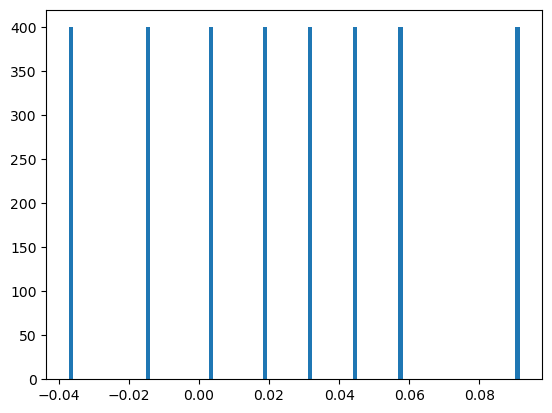

In [19]:
plt.hist(state.cpu().numpy().reshape(-1), 100);